In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px

# you need to have a clean dataset in data/cleaned_data/

unzip the one i give you, OR, run clean_data_backbone notebook

In [2]:
import os
clean_files = ['../data/cleaned_data/all_dataset.parquet']
dfs = []
for file in clean_files:
    dfs.append(pd.read_parquet(file))
df = pd.concat(dfs, axis = 0)
df.index = pd.to_datetime(df.index)
df['state_of_charge_percent'] = df['state_of_charge_percent'].clip(0,120)

# First plot

take as index timestamp

In [83]:
def save_fig(fig, path, title, extension = '.png'):
    new_folder = path + '/' + title
    isExist = os.path.exists(new_folder)
    if not isExist:
        os.makedirs(new_folder)
    fig.write_image(new_folder + '/' + title + extension)

def save_csv(data, path, title, extension = '.csv'):
    new_folder = path + '/' + title
    isExist = os.path.exists(new_folder)
    if not isExist:
        os.makedirs(new_folder)
    data.to_csv(new_folder + '/' + title + extension)

In [113]:
# this function takes as input the raw dataset
field = 'temperature'
freq = '1M'
agg_func = 'mean'

def plot_boxplot_per_freq(DF = df, field = 'temperature', freq = '1MS', metric_aggregation = 'mean', title = 'your_title', save = False):
    mean_per_freq = DF[[field,'battery_id']].groupby('battery_id').resample(freq)[field].agg(metric_aggregation)
    mean_per_freq = mean_per_freq.reset_index()
    mean_per_freq['timestamp'] = mean_per_freq['timestamp'].dt.date
    mean_per_freq = mean_per_freq.sort_values('timestamp')
    fig = px.box(mean_per_freq, x = 'timestamp', y = field, title = title);
    fig.show()

    if save == True:
        save_fig(fig, '../figs', title)
        save_csv(mean_per_freq, '../figs', title)

In [92]:
fig, data = plot_boxplot_per_freq(field = 'temperature', freq = '1MS', metric_aggregation='mean', title = 'battery_wise mean temperature of months', save = True)

(<Figure size 432x288 with 1 Axes>,       battery_id   timestamp  temperature
 412           70  2021-01-01    31.936370
 276           47  2021-01-01    33.410391
 1113         187  2021-01-01    36.717784
 623          105  2021-01-01    27.299153
 616          104  2021-01-01    35.154498
 ...          ...         ...          ...
 766          128  2021-07-01    32.687114
 771          129  2021-07-01    27.706569
 777          130  2021-07-01    30.597391
 693          116  2021-07-01    32.350652
 1193         199  2021-07-01    31.824216
 
 [1194 rows x 3 columns])

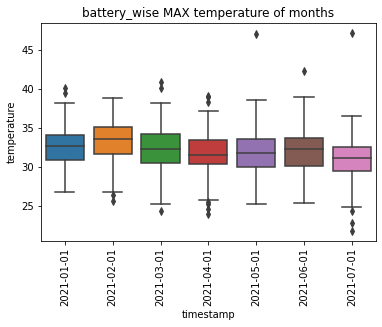

In [75]:
plot_boxplot_per_freq(field = 'temperature', freq = '1MS', metric_aggregation= 'max', title = 'battery_wise MAX temperature of months', save = True)

# Second plot

this plot

In [ ]:
# data prep
# raw data as input
resample = True
if resample == True:
    df = df.groupby('battery_id').resample('10min').mean()
    df = df.drop('battery_id', axis = 1)

    df = df.reset_index().set_index('timestamp')

df['hour'] = df.index.hour
df['minutes'] = df.index.minute
df['day_n'] = df.index.weekday

In [109]:
df_plot

battery_id,37,38,131,155,178
0H0,1.388600,2.58661,2.592970,1.376550,1.31472
0H10,1.386480,2.58661,2.593965,1.376960,1.31472
0H20,1.386480,2.58661,2.594960,1.376550,1.31472
0H30,1.386480,2.58661,2.592970,1.376550,1.31571
0H40,1.386480,2.58661,2.594960,1.376550,1.31600
...,...,...,...,...,...
23H10,1.605765,2.58916,2.593800,1.377600,1.31472
23H20,1.598200,2.58858,2.594490,1.377338,1.31472
23H30,1.577840,2.58661,2.592970,1.377600,1.31472
23H40,1.397420,2.58858,2.592970,1.377600,1.31472


In [120]:
n_battery_to_plot = 5
field = 'power_out'
freq_group_by = ['hour','minutes'] #also ['day_n','hour','minutes']
agg_method = 'mean'

randoms_ids = np.random.choice(df.battery_id.unique(), n_battery_to_plot)
subset = df[df['battery_id'].isin(randoms_ids)]

def plot_median_profile(DF, field, freq_group_by,agg_method = 'mean', title = '', path = '../figs', save = False):
    df_median = DF.groupby(['battery_id'] + freq_group_by).agg(agg_method)
    df_plot = df_median[field].unstack(level = 0).sort_index()
    df_plot.index = df_plot.index.map('{0[0]}H{0[1]}'.format) 

    fig = px.line(df_plot)
    fig.show()

    if save == True:
        save_fig(fig, path, title)
        save_csv(df_plot, path, title)

In [123]:
plot_median_profile(subset, 'state_of_charge_percent', freq_group_by, agg_method = 'mean', title = 'weely profile', save = True)

# On all data

In [13]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,10))
df_quants = df.groupby(['battery_id','binned_power'])['power_out'].count().unstack('binned_power')
df_quants = df_quants.div(df_quants.sum(axis = 1), axis = 0)

In [14]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_quants.values)
    distortions.append(kmeanModel.inertia_)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


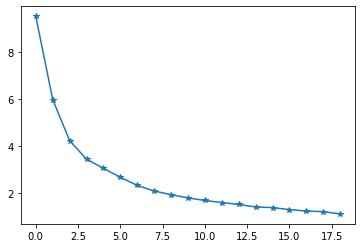

In [15]:
plt.plot(distortions, marker = '*')

In [16]:
n_clusters = 3
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(df_quants.values).labels_
y_bin = label_binarize(y, classes=np.arange(0,n_clusters))
clf=RandomForestClassifier()
clf.fit(df_quants.values,y)

RandomForestClassifier()

Feature importance for cluster 0


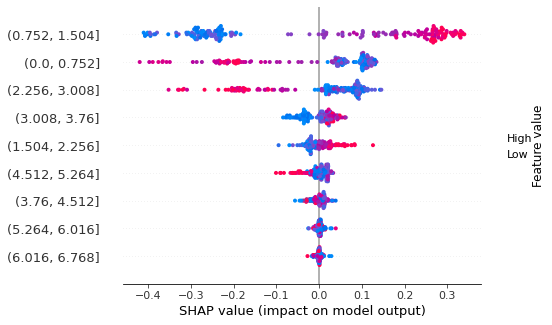

Feature importance for cluster 1


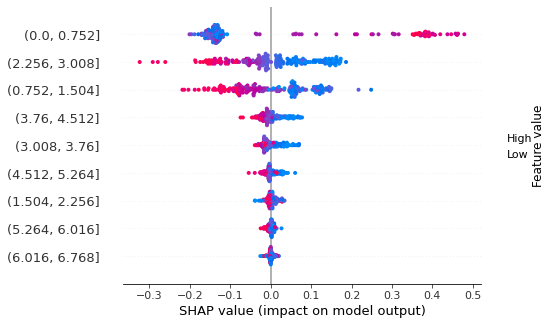

Feature importance for cluster 2


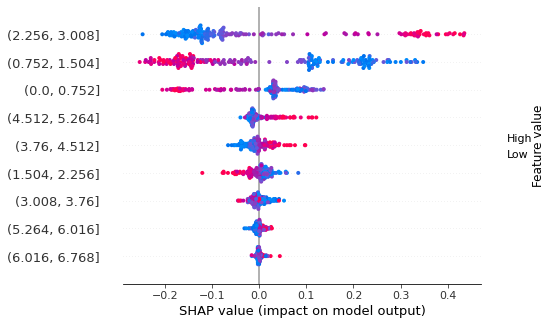

In [17]:
import shap

explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_quants)
for k in range(n_clusters):
    print(f'Feature importance for cluster {k}')
    shap.plots.beeswarm(shap_values[:,:,k])


In [18]:
id_to_class = pd.DataFrame(data = y, index = df_quants.index, columns = ['class']).squeeze().to_dict()

[Text(0, 0, '(0.0, 0.752]'),
 Text(1, 0, '(0.752, 1.504]'),
 Text(2, 0, '(1.504, 2.256]'),
 Text(3, 0, '(2.256, 3.008]'),
 Text(4, 0, '(3.008, 3.76]'),
 Text(5, 0, '(3.76, 4.512]'),
 Text(6, 0, '(4.512, 5.264]'),
 Text(7, 0, '(5.264, 6.016]'),
 Text(8, 0, '(6.016, 6.768]')]

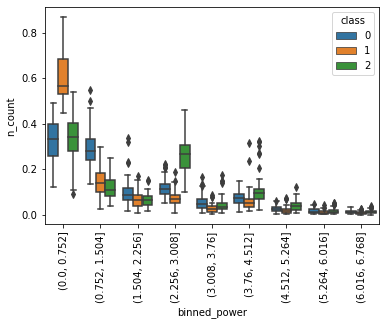

In [19]:
df_quants = df_quants.stack()
df_quants = df_quants.rename('n_count')
df_quants = df_quants.reset_index()
df_quants['class'] = df_quants['battery_id'].map(id_to_class)

ax = sns.boxplot(data = df_quants, x = 'binned_power', y = 'n_count', hue = 'class')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# Month by month

In [41]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,10))
df['month'] = df.index.month
df_quants = df.groupby(['battery_id','month','binned_power'])['power_out'].count().unstack('binned_power')

In [42]:
df_quants = df_quants.div(df_quants.sum(axis = 1), axis = 0)

In [43]:
df_quants = df_quants.dropna()

In [44]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_quants.values)
    distortions.append(kmeanModel.inertia_)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.


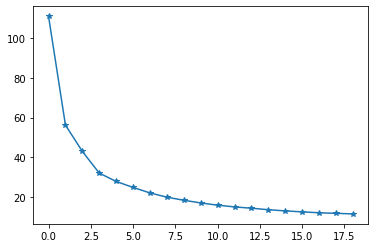

In [45]:
plt.plot(distortions, marker = '*')

In [46]:
n_clusters = 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(df_quants.values).labels_
y_bin = label_binarize(y, classes=np.arange(0,n_clusters))
clf=RandomForestClassifier()
clf.fit(df_quants.values,y)

RandomForestClassifier()

Feature importance for cluster 0


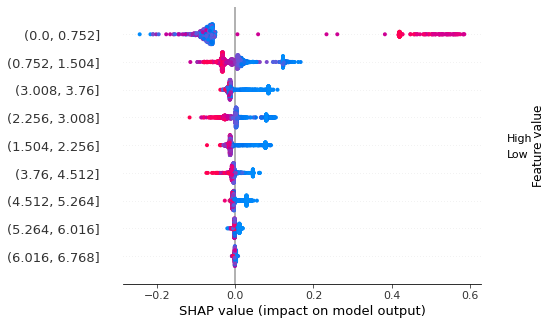

Feature importance for cluster 1


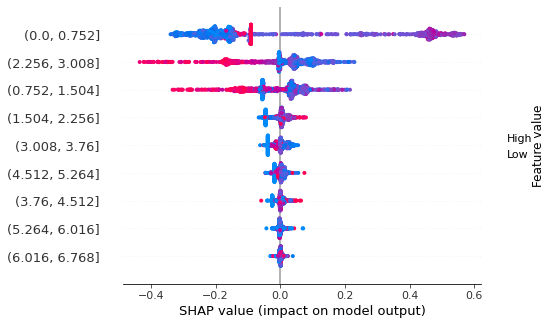

Feature importance for cluster 2


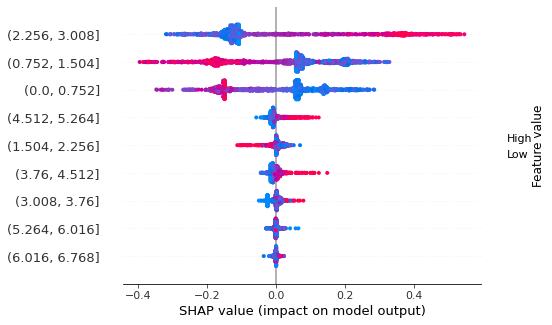

Feature importance for cluster 3


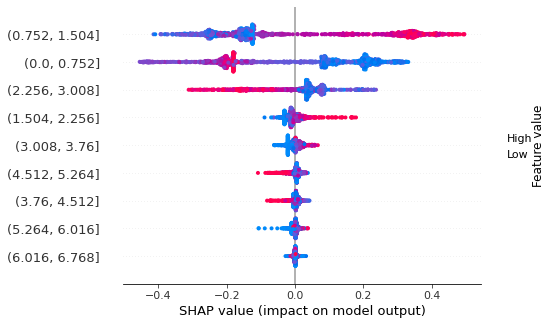

In [47]:
import shap

explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_quants)
for k in range(n_clusters):
    print(f'Feature importance for cluster {k}')
    shap.plots.beeswarm(shap_values[:,:,k])


In [48]:
id_to_class = pd.DataFrame(data = y, index = df_quants.index, columns = ['class']).squeeze().to_dict()

In [55]:
df_quants = df_quants.stack()
df_quants = df_quants.rename('n_count')
df_quants = df_quants.reset_index().set_index(['battery_id','month'])

In [57]:
df_quants['class'] = df_quants.index.map(id_to_class)

In [63]:
df_quants = df_quants.reset_index()

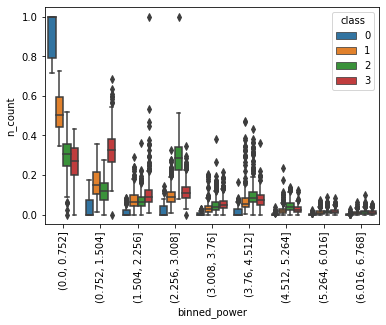

In [65]:
ax = sns.boxplot(data = df_quants, x = 'binned_power', y = 'n_count', hue = 'class')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

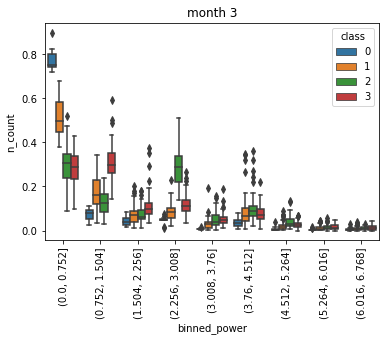

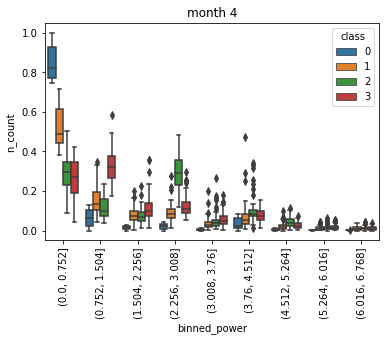

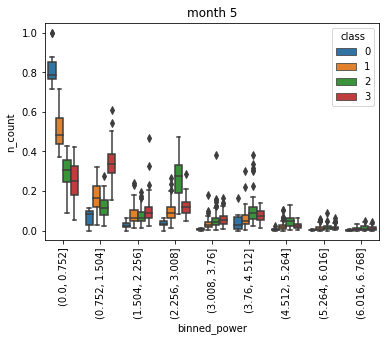

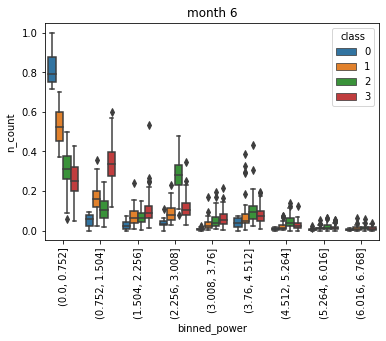

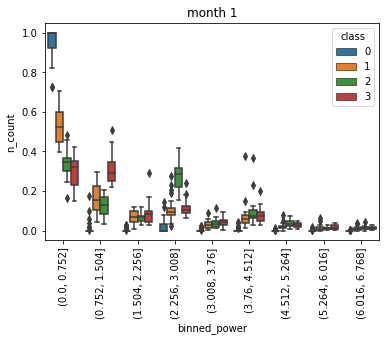

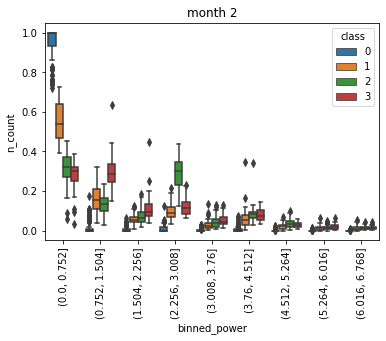

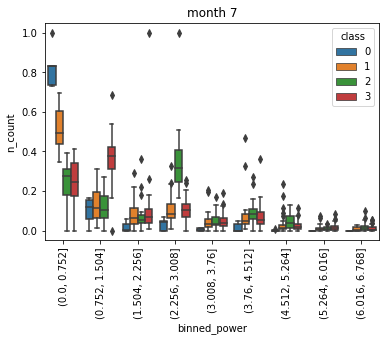

In [68]:
for k in df_quants.month.unique():
    sub_df = df_quants[df_quants['month'] == k]
    plt.figure()
    plt.title(f'month {k}')
    ax = sns.boxplot(data = sub_df, x = 'binned_power', y = 'n_count', hue = 'class')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
    plt.show()

# Cluster vs Time

In [85]:
df_quants

,battery_id,month,binned_power,n_count,class
0,0,3,"(0.0, 0.752]",0.439019,1
1,0,3,"(0.752, 1.504]",0.044393,1
2,0,3,"(1.504, 2.256]",0.073598,1
3,0,3,"(2.256, 3.008]",0.071729,1
4,0,3,"(3.008, 3.76]",0.010280,1
...,...,...,...,...,...
10687,199,7,"(3.008, 3.76]",0.049423,1
10688,199,7,"(3.76, 4.512]",0.031301,1
10689,199,7,"(4.512, 5.264]",0.176277,1
10690,199,7,"(5.264, 6.016]",0.004942,1


<AxesSubplot:xlabel='month', ylabel='battery_id'>

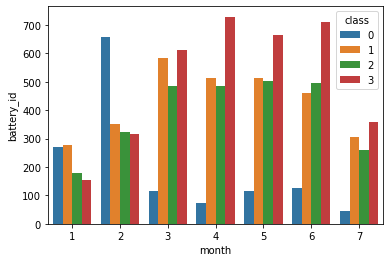

In [109]:
sns.barplot(data = df_quants.groupby(['month','class']).count()['battery_id'].reset_index(), x = 'month', y = 'battery_id',hue= 'class')

In [88]:
df_battery_month = df_quants[['battery_id','month','class']].drop_duplicates().set_index(['battery_id','month']).unstack('month')

In [94]:
df_battery_month.columns = df_battery_month.columns.droplevel(0)
df_battery_month

month,1,2,3,4,5,6,7
battery_id,,,,,,,
0,NaN,NaN,1.0,2.0,2.0,1.0,NaN
1,1.0,3.0,3.0,3.0,3.0,3.0,3.0
2,1.0,1.0,0.0,1.0,1.0,0.0,NaN
3,3.0,3.0,3.0,3.0,3.0,3.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...
195,NaN,0.0,3.0,3.0,2.0,3.0,3.0
196,1.0,1.0,3.0,3.0,3.0,3.0,3.0
197,NaN,0.0,3.0,2.0,2.0,2.0,1.0


In [118]:
cmap = sns.color_palette(n_colors=4)


<AxesSubplot:xlabel='month', ylabel='battery_id'>

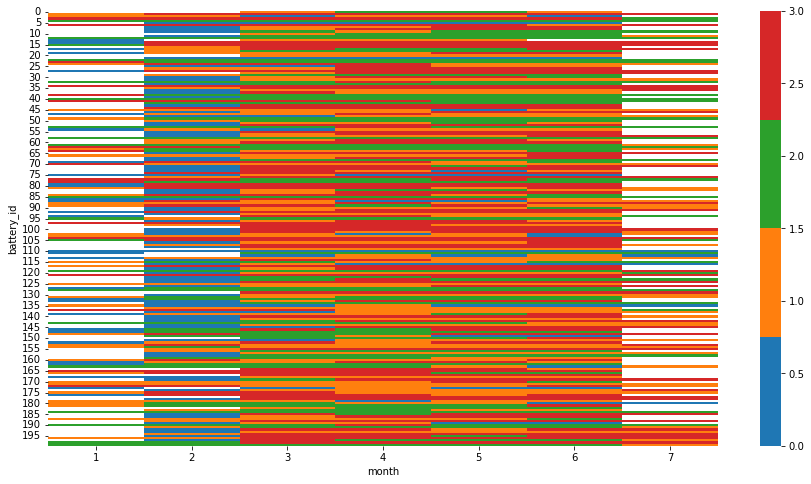

In [119]:
plt.figure(figsize = (15,8))
sns.heatmap(df_battery_month, cmap=cmap)


In [117]:
df_battery_month

month,1,2,3,4,5,6,7
battery_id,,,,,,,
0,NaN,NaN,1.0,2.0,2.0,1.0,NaN
1,1.0,3.0,3.0,3.0,3.0,3.0,3.0
2,1.0,1.0,0.0,1.0,1.0,0.0,NaN
3,3.0,3.0,3.0,3.0,3.0,3.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...
195,NaN,0.0,3.0,3.0,2.0,3.0,3.0
196,1.0,1.0,3.0,3.0,3.0,3.0,3.0
197,NaN,0.0,3.0,2.0,2.0,2.0,1.0


In [76]:
df_quants.pivot(index = ['battery_id','month'], values='class')

TypeError: pivot() missing 1 required argument: 'columns'

In [72]:
sns.heatmap(data = df_quants, x = 'month', y = 'battery_id', hue = 'class')

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'